In [1]:
!pip install yfinance
!pip install numpy
!pip install pandas
!pip install statsmodels
!pip install arch
!pip install matplotlib
!pip install seaborn



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.6/863.6 kB 8.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


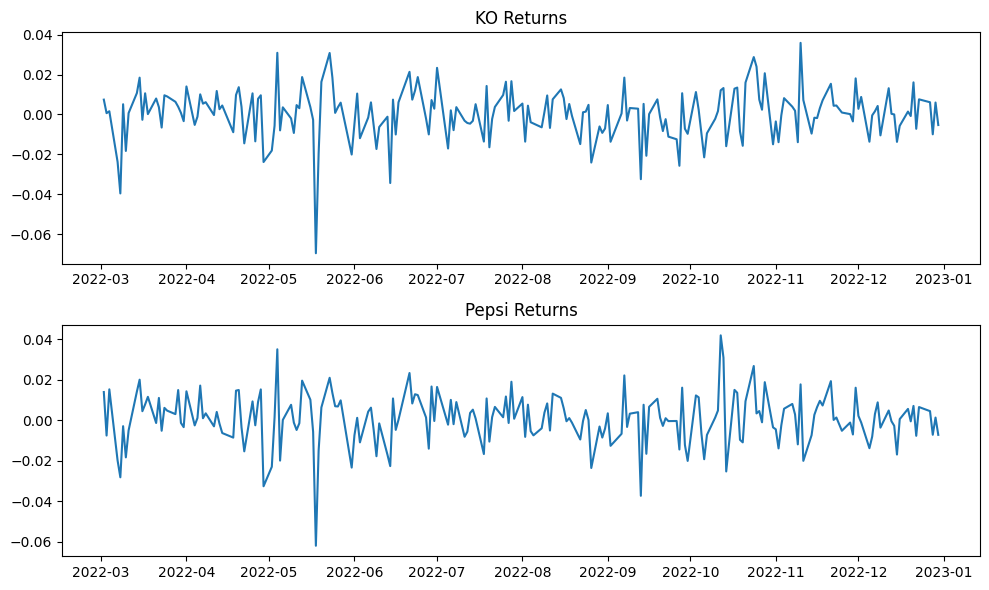

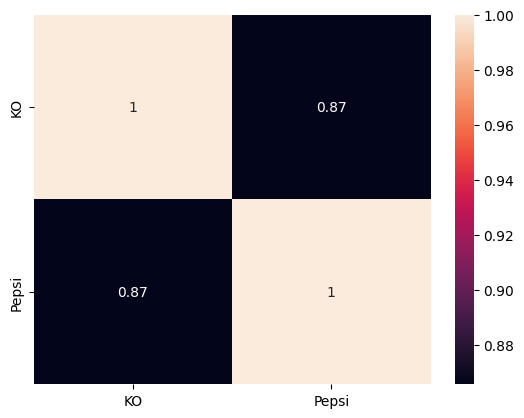

Correlation:  0.8655547038140028
Cointegration test p-value:  2.5881545210231167e-15
ADF Statistic:  -9.574457662915588
p-value:  2.242721306035242e-16
Durbin-Watson statistic:  1.7379337215118749


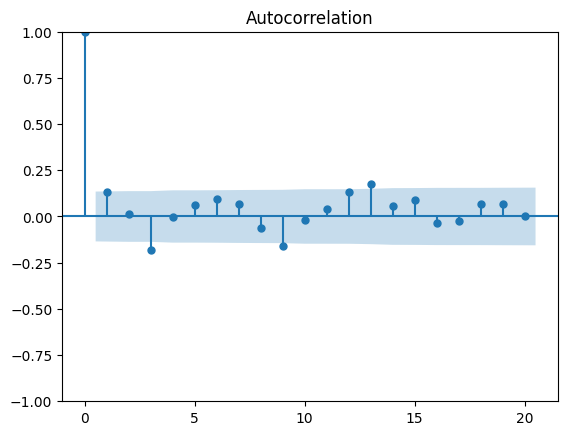

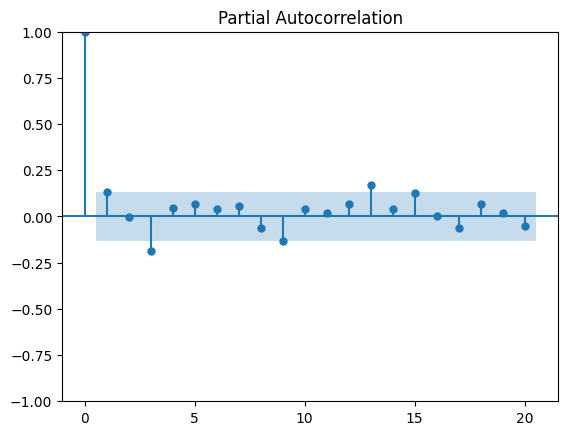

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                622.900
Distribution:                  Normal   AIC:                          -1237.80
Method:            Maximum Likelihood   BIC:                          -1224.39
                                        No. Observations:                  211
Date:                Thu, Jun 22 2023   Df Residuals:                      210
Time:                        18:45:05   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.9220e-04  8.673e-04      0.222      0.825 

/Users/ianmcdevitr/miniconda3/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001607. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [12]:
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson
from arch import arch_model
import matplotlib.pyplot as plt
import seaborn as sns

# Fetching data
start_date = '2022-03-01'
end_date = '2023-01-01'

try:
    pepsi = yf.download('PEP', start=start_date, end=end_date)
    ko = yf.download('KO', start=start_date, end=end_date)
except Exception as e:
    print("Error in downloading data: ", e)
    raise

# Data Validation
assert 'Close' in ko.columns, "KO data does not have 'Close' column"
assert 'Close' in pepsi.columns, "Pepsi data does not have 'Close' column"

# Handle missing data
ko = ko.dropna()
pepsi = pepsi.dropna()

# Convert the 'Close' column into returns
try:
    ko_returns = ko['Close'].pct_change().dropna()
    pepsi_returns = pepsi['Close'].pct_change().dropna()
except Exception as e:
    print("Error in calculating returns: ", e)
    raise

# Visualizations
fig, axs = plt.subplots(2, figsize=(10,6))
axs[0].plot(ko_returns)
axs[0].set_title('KO Returns')
axs[1].plot(pepsi_returns)
axs[1].set_title('Pepsi Returns')
plt.tight_layout()
plt.show()

# Correlation Matrix
sns.heatmap(pd.DataFrame({'KO': ko_returns, 'Pepsi': pepsi_returns}).corr(), annot=True)
plt.show()

# Calculate the correlation between the returns of the two stocks
correlation = ko_returns.corr(pepsi_returns)
print('Correlation: ', correlation)

# Perform a cointegration test on the returns of the two stocks
score, p_value, _ = coint(ko_returns, pepsi_returns)
print('Cointegration test p-value: ', p_value)

# Perform a linear regression to find the hedge ratio
X = sm.add_constant(pepsi_returns)
result = sm.OLS(ko_returns, X).fit()
hedge_ratio = result.params[1]

# Calculate the spread
spread = ko_returns - hedge_ratio * pepsi_returns

# Perform the Augmented Dickey-Fuller test on the spread
adf_result = adfuller(spread)
print('ADF Statistic: ', adf_result[0])
print('p-value: ', adf_result[1])

# Perform the Durbin-Watson test on the residuals
dw_result = durbin_watson(result.resid)
print('Durbin-Watson statistic: ', dw_result)

# Autocorrelation in residuals
plot_acf(result.resid, lags=20)
plot_pacf(result.resid, lags=20)
plt.show()

# Fit a GARCH(1, 1) model to the returns
model = arch_model(ko_returns, vol='Garch', p=1, q=1)
model_fit = model.fit(disp='off')

# Print the summary of the model fit
print(model_fit.summary())
# Checks for pairs trading opportunity
if correlation > 0.5 and p_value < 0.05 and adf_result[1] < 0.05:
    print(f'This is a good pairs trading opportunity.')
    print(f'Correlation: {correlation}')
    print(f'Cointegration test p-value: {p_value}')
    print(f'ADF test p-value: {adf_result[1]}')
else:
    print(f'This is not a good pairs trading opportunity.')
    print(f'Correlation: {correlation}')
    print(f'Cointegration test p-value: {p_value}')
    print(f'ADF test p-value: {adf_result[1]}')
